# Sentiment agent model

Creating a sentiment agent model that may predict the mean sentiment of microblogging environment by predicting the influence of existing posts on a posting agent. 

Written by Luc Bijl.

## The subset $S$ of the set of all posts $P$

Importing the test posts set.

In [1]:
import pandas as pd

# Importing the csv dataset
import_posts = 'test-posts-scores.csv'
df_posts = pd.read_csv(import_posts)

df_posts.head(6)

,Date,Text,S,V,A,D
0,2024-01-02 14:40:00,I hate my fucking life.,-0.482720,-0.430294,0.612063,0.354783
1,2024-01-01 12:12:31,"Greetings fellow humanoid, how are you doing?",0.246881,0.450770,0.407472,0.218679
2,2023-12-31 19:39:00,This microblogging platform is dismal in every...,-0.447901,-0.445385,0.118963,0.152460
3,2023-12-28 06:12:00,Politics is a joke.,-0.411837,0.663786,0.738927,0.440982
4,2023-12-26 13:25:00,I am sorry for my bad behaviour. Can I make it...,0.118153,-0.096516,0.142977,-0.136444
5,2023-12-12 16:16:16,"The universe is irrational and meaningless, I ...",-0.465270,-0.028720,0.032311,0.033977


Creating the set $P$ of all posts, by taking a time point $t_0$ for which the model should start.

In [2]:
# Stating the time point
t_0 = pd.to_datetime('2024-01-03 00:00:00')

# Defining the set P of all posts
P = []

# Determining the posts from before the time point and appending the necessary information to P
for index, row in df_posts.iterrows():
    t_row = pd.to_datetime(row['Date'])
    if t_row < t_0:
        P.append([t_0 - t_row] + list(row[['S', 'V', 'A', 'D']]))

df_P = pd.DataFrame(P, columns=['age', 's', 'v', 'a', 'd'])

df_P.head(6)

,age,s,v,a,d
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783
1,1 days 11:47:29,0.246881,0.450770,0.407472,0.218679
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460
3,5 days 17:48:00,-0.411837,0.663786,0.738927,0.440982
4,7 days 10:35:00,0.118153,-0.096516,0.142977,-0.136444
5,21 days 07:43:44,-0.465270,-0.028720,0.032311,0.033977


Determining the probability to be included in the subset $S$.

In [3]:
import numpy as np

# Defining the various probability functions.
def g_age(p_age):
        a = 0.1
        return a * np.exp(-(a*p_age.days))

def g_s(p_s):
      a_1 = 0.4
      a_2 = 0.6
      b_1 = 2
      b_2 = 2
      c_1 = 1
      c_2 = -1
      return a_1 * np.exp(-b_1 * (p_s - c_1)**2) + a_2 * np.exp(-b_2 * (p_s - c_2)**2)

def g_v(p_v):
      a_1 = 0.4
      a_2 = 0.6
      b_1 = 1
      b_2 = 1
      c_1 = 1
      c_2 = -1
      return a_1 * np.exp(-b_1 * (p_v - c_1)**2) + a_2 * np.exp(-b_2 * (p_v - c_2)**2)

def g_a(p_a):
      a = 0.5
      return np.exp(a * p_a) * a / (np.exp(a) - np.exp(-a))

def g_d(p_d):
      return 1

# Defining the main probability function.
def g(p):
      output = g_age(p['age']) * g_s(p['s']) * g_v(p['v']) * g_a(p['a']) * g_d(p['d'])
      return output

# Determining the normalization sum of g for P.
normal_sum = sum(g(row.to_dict()) for _, row in df_P[['age', 's', 'v', 'a', 'd']].iterrows())

# Determining the probability for each entry in P.
df_P['rho'] = [g(row.to_dict()) for _, row in df_P[['age', 's', 'v', 'a', 'd']].iterrows()] / normal_sum

df_P.head(6)

,age,s,v,a,d,rho
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783,0.397931
1,1 days 11:47:29,0.246881,0.450770,0.407472,0.218679,0.107785
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460,0.239942
3,5 days 17:48:00,-0.411837,0.663786,0.738927,0.440982,0.180755
4,7 days 10:35:00,0.118153,-0.096516,0.142977,-0.136444,0.046563
5,21 days 07:43:44,-0.465270,-0.028720,0.032311,0.033977,0.027024


Creating the subset $S$.

In [4]:
# Defining the cardinality m of the subset S.
m = 3

# Creating the subset.
df_S = df_P.loc[np.random.choice(df_P.index, size=m, replace=False, p=df_P['rho'])]

df_S.head()

,age,s,v,a,d,rho
0,0 days 09:20:00,-0.482720,-0.430294,0.612063,0.354783,0.397931
2,2 days 04:21:00,-0.447901,-0.445385,0.118963,0.152460,0.239942
4,7 days 10:35:00,0.118153,-0.096516,0.142977,-0.136444,0.046563


## The initial state of the agent

Creating the probability distribution function of the set $P$ and the initial state function.

In [5]:
from sklearn.neighbors import KernelDensity

# Defining the bandwidth of the kernel density function.
kernel_bandwidth = 0.1

# Defining the initial state function.
def create_initial_state(df_P, bandwidth):
    kde_models = {}

    # Fitting a kde for each column.
    for i in ['s', 'v', 'a', 'd']:
        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(df_P[i].values.reshape(-1,1))
        kde_models[i] = kde

    # Generating a new random entry for each column.
    new_entries = {}
    for i, kde_model in kde_models.items():
        new_entry = np.clip(kde_model.sample(), -1, 1)
        new_entries[i] = new_entry.item()
    
    return new_entries

# Creating an initial state with the defined function.
u = create_initial_state(df_P, kernel_bandwidth)

print(u)

{'s': -0.44804590169654096, 'v': -0.0832535429011578, 'a': 0.3861707225182225, 'd': 0.3345037293968123}


Creating a plot of the probability distributions of the set $P$. 

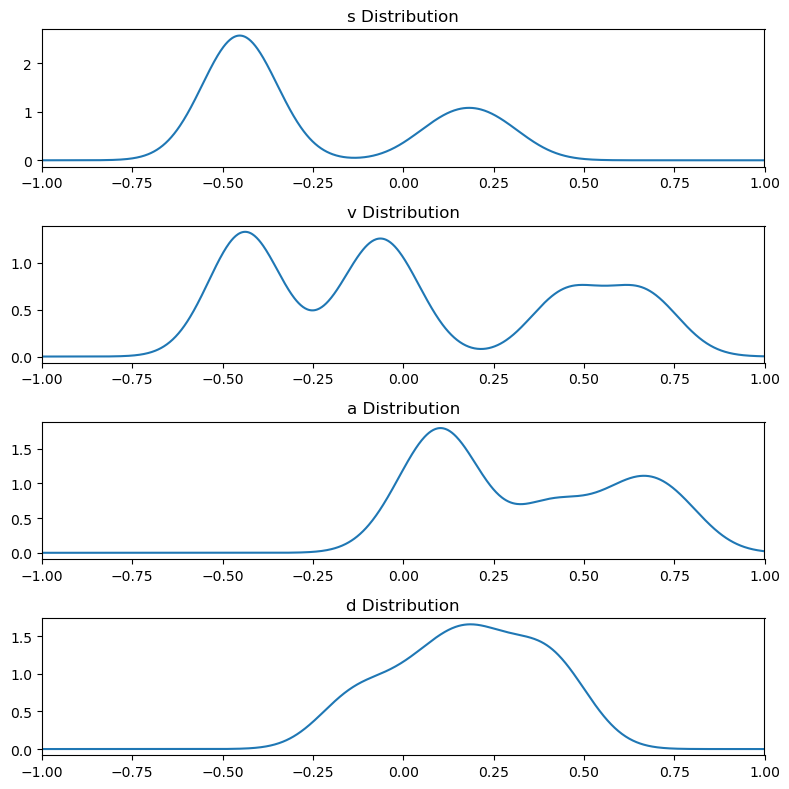

In [45]:
import matplotlib.pyplot as plt

# Choose the columns for KDE
columns_to_kde = ['s', 'v', 'a', 'd']

# Set up subplots for each column
fig, axes = plt.subplots(nrows=len(columns_to_kde), figsize=(8, 2 * len(columns_to_kde)))

# Fit a separate KDE for each column and plot the distribution
for i, col in enumerate(columns_to_kde):
    col_data = df_P[col].values.reshape(-1, 1)
    
    # Fit KDE
    kde = KernelDensity(bandwidth=kernel_bandwidth, kernel='gaussian')
    kde.fit(col_data)
    
    # Generate x values for the plot
    x_values = np.linspace(-1, 1, 1000).reshape(-1, 1)
    
    # Evaluate the KDE at the x values
    log_dens = kde.score_samples(x_values)
    density = np.exp(log_dens)
    
    # Plot the distribution
    axes[i].plot(x_values, density, label=f'{col} Distribution')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlim(-1, 1)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## The influence function

Creating the probability influence function. 

In [6]:
# Defining the various probability influence functions
def I_s(u, p, epsilon):
    mu_1, mu_2 = 1, 10
    sigma_1, sigma_2 = 1, 2
    mu = mu_1 * mu_2**(u['a'] + p['a'] - u['d'] + p['d'] - 4)
    sigma = sigma_1 * sigma_2**(-(u['v'] - p['v'])**2 - (u['s'] - p['s'])**2)
    return np.exp((-1 / (2 * sigma**2)) * (epsilon - mu)**2) * 1 / (sigma * np.sqrt(2 * np.pi))

def I_v(u, p, epsilon):
    mu = 0.1
    return np.exp(mu * epsilon) * mu / (np.exp(mu) - np.exp(-mu))

def I_a(u, p, epsilon):
    mu = 0.1
    return np.exp(mu * epsilon) * mu / (np.exp(mu) - np.exp(-mu))

def I_d(u, p, epsilon):
    mu = 0.1
    return np.exp(mu * epsilon) * mu / (np.exp(mu) - np.exp(-mu))

# Defining the inverse transform function.
def inverse_transform(u, p, pdf):
    values = np.linspace(-1, 1, 1000)

    cdf_values = np.cumsum(pdf(u, p, values))
    cdf_values /= cdf_values[-1]

    sample = np.random.rand(1)

    inverse_sample = np.interp(sample, cdf_values, values)

    return inverse_sample

# Defining the probability influence function.
def probability_influence_function(u, p):

    # Determing the influence factors by taking the inverse transforms of the various probability influence functions.
    epsilon_s = inverse_transform(u, p, I_s)
    epsilon_v = inverse_transform(u, p, I_v)
    epsilon_a = inverse_transform(u, p, I_a)
    epsilon_d = inverse_transform(u, p, I_d)

    # Creating the diagonal matrix E, with the influence factors.
    E = np.diag([epsilon_s, epsilon_v, epsilon_a, epsilon_d])
    return (1/2) * (np.array(list(u.values())) + np.dot(E, np.array(list(p.values())).reshape(1,4)))

v = (1/m) * sum(probability_influence_function(u, row.to_dict()) for _, row in df_S[['s', 'v', 'a', 'd']].iterrows())

print(v)

[-0.17524875  0.00763285  0.20014595  0.15760669]


Testing the probability distribution of the influence factors.

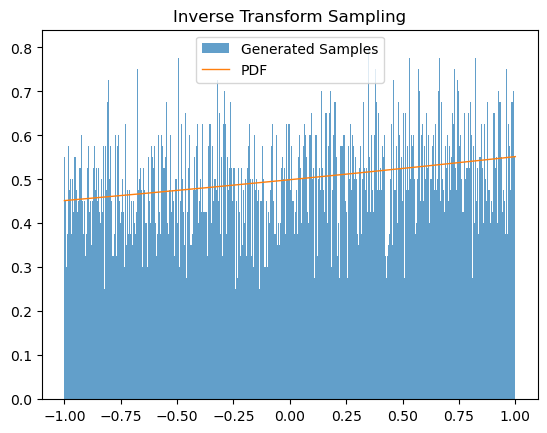

In [47]:
def sample_inverse_transform(u, p, pdf):
    values = np.linspace(-1, 1, 1000)

    cdf_values = np.cumsum(pdf(u, p, values))
    cdf_values /= cdf_values[-1]

    sample = np.random.rand(10000)

    inverse_sample = np.interp(sample, cdf_values, values)

    return inverse_sample

p = {'s': 0.6, 'v': 0.4, 'a': 1, 'd': 1}
u = {'s': 0.3, 'v': -0.2, 'a': 1, 'd': 0}

sample = sample_inverse_transform(u, p, I_v)

plt.hist(sample, bins=500, density=True, alpha=0.7, label='Generated Samples')
values = np.linspace(-1, 1, 1000)
plt.plot(values, I_v(u, p, values), label='PDF', linewidth=1)
plt.title('Inverse Transform Sampling')
plt.legend()
plt.show()

Creating the simple influence function.

In [48]:
# Defining the simple influence function.
def simple_influence_function(u, p):
    return (1/2) * (np.array(list(u.values())) + np.array(list(p.values())))

v = (1/m) * sum(probability_influence_function(u, row.to_dict()) for _, row in df_S[['s', 'v', 'a', 'd']].iterrows())

print(v)

[ 0.14895439 -0.15606495  0.43654564 -0.02727863]


Creating the coupled influence function.

In [49]:
# Defining the coupled influence function.
def coupled_influence_function(u, p):
    v_1 = 2 * u['s'] + (1 - u['d']) * (1 + u['a']) * (1 + p['a']) * p['s']
    v_2 = 7 * u['v'] + 3 * p['v']
    v_3 = 6 * u['a'] + 4 * p['a']
    v_4 = 6 * u['d'] + 4 * u['d']
    return (1/10) * np.array([v_1, v_2, v_3, v_4])

v = (1/m) * sum(probability_influence_function(u, row.to_dict()) for _, row in df_S[['s', 'v', 'a', 'd']].iterrows())

print(v)

[ 0.08685971 -0.13036836  0.52598485  0.02677245]


## The post probability

Defining the post probability functions.

In [7]:
# Defining the various post probability functions.
def h_s(v_s):
    mu_1 = 1
    mu_2 = 1
    nu_1 = 1
    nu_2 = 1
    rho_1 = 1
    rho_2 = -1
    return mu_1 * np.exp(-nu_1 * (v_s - rho_1)**2) + mu_2 * np.exp(-nu_2 * (v_s - rho_2)**2)
    
def h_v(v_p):
    mu_1 = 1
    mu_2 = 1
    nu_1 = 1
    nu_2 = 1
    rho_1 = 1
    rho_2 = -1
    return mu_1 * np.exp(-nu_1 * (v_p - rho_1)**2) + mu_2 * np.exp(-nu_2 * (v_p - rho_2)**2)
    
def h_a(v_a):
    mu = 0.2
    return np.exp(mu * v_a) * (mu + 0.1) / (np.exp(mu) - np.exp(-mu))

def h_d(v_d):
    mu = 0.2
    return np.exp(mu * v_d) * (mu + 0.1) / (np.exp(mu) - np.exp(-mu))

# Defining the post probability function.
def h(v):
    return h_s(v['s']) * h_v(v['v']) * h_a(v['a']) * h_d(v['d'])

Defining the post boolean return function based on h.

In [8]:
from scipy.integrate import nquad

v = {'s': 1, 'v': 1, 'a': 1, 'd': 1}

# Defining the post probability function wrapper.
def wrapper_h(v_s, v_v, v_a, v_d):
    v = {'s': v_s, 'v': v_v, 'a': v_a, 'd': v_d}
    return h(v)

# Defining the post boolean return function based on h.
def post_boolean(h_image):
    interval = [[-1,1], [-1,1], [-1,1], [-1,1]]

    # Determining the normal integral of the post probability function.
    normal_sum, error = nquad(wrapper_h, interval)

    # Determining the probabality by normalizing the image of h with the normal sum.
    probability = h_image / normal_sum

    return np.random.choice([True, False], p=[probability, 1 - probability])

post_boolean(h(v))

False